In [2]:
## Homework 5 Solution Template
### CSCI 4270 / 6270
### Spring 2025

**Analysis**

The following object detection model uses the pre-trained ResNet-18 backbone, with the final fully connected layer removed provided by the starter code. On top of this frozen backbone, I added two separate fully connected layers: one for classification (outputting C+1 neurons where class 0 denotes "nothing") and one for regression(4 coords per class for the box). The training of the network used a loss function that combined cross-entropy for classification and mean squared error for bounding box regression. Although the model generally detected the correct object classes during testing, the predicted bounding boxes seemed to be less constrictive than the ground truth, not tightly fitting the objects. This is likely due to the limited training (only 2 epochs because of time constraints and my device not being able to dataload in parallel resulting in num_workers=0). This suggests that additional epochs may help improve the refining of regression outputs which would then imporve the accuracy of localization for detection.

In [3]:
import numpy as np
import json
from PIL import Image
from os.path import join

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import models
import torchvision.transforms as transforms

In [4]:
"""
Implement and test the utilities in support of evaluating the results
from the region-by-region decisions and turning them into detections.

All rectangles are four component lists (or tuples) giving the upper
left and lower right corners of an axis-aligned rectangle.  For example, 
[2, 9, 12, 18] has upper left corner (2,9) and lower right (12, 18)

The region predictions for an image are stored in a list of dictionaries,
each giving the class, the activation and the bounding rectangle.
For example,

{
    "class": 2,
    "a":  0.67,
    "rectangle": (18, 14, 50, 75)
}

if the class is 0 this means there is no detection and the rectangle
should be ignored.  The region predictions must be turned into the
detection results by filtering those with class 0 and through non
maximum supression.  The resulting regions should be considered the
"detections" for the image.

After this, detections should be compared to the ground truth 

The ground truth regions for an image are stored as a list of dictionaries. 
Each dictionary contains the region's class and bounding rectangle.
Here is an example dictionary:

{
    "class":  3,
    "rectangle": (15, 20, 56, 65)
}

Class 0 will not appear in the ground truth.  
"""

def area(rect):
    h = rect[3] - rect[1]
    w = rect[2] - rect[0]
    return h * w


def iou(rect1, rect2):
    """
    Input: two rectangles
    Output: IOU value, which should be 0 if the rectangles do not overlap.
    """ 
    x0, y0, x1, y1 = rect1
    u0, v0, u1, v1 = rect2
    ir = (max(x0, u0), max(y0, v0), min(x1, u1), min(y1, v1))
    if ir[0] >= ir[2] or ir[1] >= ir[3]:
        return 0
    else:
        return area(ir) / (area(rect1) + area(rect2) - area(ir))


def predictions_to_detections(predictions, iou_threshold=0.5):
    """
    Input: List of region predictions

    Output: List of region predictions that are considered to be
    detection results. These are ordered by activation with all class
    0 predictions eliminated, and non-maximum suppression
    applied.
    """
    #filter out predictions with class 0 ("nothing")
    preds = [p for p in predictions if p["class"] != 0]
    
    #dict of predictions by class
    from collections import defaultdict
    preds_by_class = defaultdict(list)
    for p in preds:
        preds_by_class[p["class"]].append(p)
    
    detections = []
    #for each class, sort predictions by activation (descending) and apply NMS
    for cls, preds_list in preds_by_class.items():
        preds_list = sorted(preds_list, key=lambda x: x["a"], reverse=True)
        kept = []
        for p in preds_list:
            keep = True
            for q in kept:
                if iou(p["rectangle"], q["rectangle"]) >= iou_threshold:
                    keep = False
                    break
            if keep:
                kept.append(p)
        detections.extend(kept)
    
    #sort the final detections by activation in descending order
    detections = sorted(detections, key=lambda x: x["a"], reverse=True)
    return detections



def evaluate(detections, gt_detections, iou_threshold=0.5):
    """
    Input:
    1. The detections returned by the predictions_to_detections function
    2. The list of ground truth regions, and
    3. The IOU threshold

    The calculation must compare each detection region to the ground
    truth detection regions to determine which are correct and which
    are incorrect.  Finally, it must compute the average precision for
    up to n detections.

    Returns:
    list of correct detections,
    list of incorrect detections,
    list of ground truth regions that are missed,
    AP@n value.
    """
    detections = sorted(detections, key=lambda x: x["a"], reverse=True)
    
    #copy of ground truth detections so we can remove matches
    gt_remaining = [gt.copy() for gt in gt_detections]
    
    binary_vector = []
    correct_detections = []
    incorrect_detections = []
    
    for det in detections:
        #find all ground truth regions of the same class
        candidates = [gt for gt in gt_remaining if gt["class"] == det["class"]]
        best_iou = 0
        best_match = None
        for gt in candidates:
            curr_iou = iou(det["rectangle"], gt["rectangle"])
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_match = gt
        #determine if the detection is correct
        if best_match is not None and best_iou >= iou_threshold:
            binary_vector.append(1)
            correct_detections.append(det)
            #remove the matched ground truth so it is not used again
            gt_remaining.remove(best_match)
        else:
            binary_vector.append(0)
            incorrect_detections.append(det)
    
    #number of ground truth objects (m)
    m = len(gt_detections)
    #if no detections, AP is defined as 0
    if len(binary_vector) == 0:
        return correct_detections, incorrect_detections, gt_remaining, 0.0

    #compute cumulative sums to get precision and recall at each detection
    import numpy as np
    binary_vector = np.array(binary_vector)
    cumsum = np.cumsum(binary_vector)
    precisions = cumsum / (np.arange(1, len(binary_vector) + 1))
    recalls = cumsum / m

    #compute the 11-point interpolated precision
    interpolated_precisions = []
    for r_level in np.linspace(0, 1, 11):
        #for each recall level, get the maximum precision for recall >= r_level
        if np.any(recalls >= r_level):
            max_prec = np.max(precisions[recalls >= r_level])
        else:
            max_prec = 0.0
        interpolated_precisions.append(max_prec)
    ap = np.mean(interpolated_precisions)

    #gt_remaining now contains ground truth objects that were not detected (missed)
    missed_gt = gt_remaining

    return correct_detections, incorrect_detections, missed_gt, ap

In [5]:
def test_iou():
    """
    Use this function for you own testing of your IOU function
    """
    # should be .370
    rect1 = (0, 5, 11, 15)
    rect2 = (2, 9, 12, 18)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0
    rect1 = (2, -3, 11, 4)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0.2
    rect1 = (3, 12, 9, 15)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

test_iou()

iou for (0, 5, 11, 15) (2, 9, 12, 18) is 0.37
iou for (2, -3, 11, 4) (2, 9, 12, 18) is 0.00
iou for (3, 12, 9, 15) (2, 9, 12, 18) is 0.20


In [6]:
def test_evaluation_code(in_json_file):
    with open(in_json_file, "r") as in_fp:
        data = json.load(in_fp)
    
    region_predictions = data["region_predictions"]
    gt_detections = data["gt_detections"]

    detections = predictions_to_detections(region_predictions)
    print(f"DETECTIONS: count = {len(detections)}")
    if len(detections) >= 2:
        print(f"DETECTIONS: first activation {detections[0]['a']:.2f}" )
        print(f"DETECTIONS: last activation {detections[-1]['a']:.2f}")
    elif len(detections) == 1:
        print(f"DETECTIONS: only activation {detections[0]['a']:.2f}")
    else:
        print(f"DETECTIONS: no activations")

    correct, incorrect, missed, ap = evaluate(detections, gt_detections)

    print(f"AP: num correct {len(correct)}")
    if len(correct) > 0:
        print(f"AP: first correct activation {correct[0]['a']:.2f}")

    print(f"AP: num incorrect {len(incorrect)}")
    if len(incorrect) > 0:
        print(f"AP: first incorrect activation {incorrect[0]['a']:.2f}")

    print(f"AP: num ground truth missed {len(missed)}")
    print(f"AP: final AP value {ap:1.3f}")


In [7]:
test_evaluation_code('eval_test1.json')

DETECTIONS: count = 3
DETECTIONS: first activation 0.90
DETECTIONS: last activation 0.69
AP: num correct 1
AP: first correct activation 0.90
AP: num incorrect 2
AP: first incorrect activation 0.70
AP: num ground truth missed 2
AP: final AP value 0.364


In [8]:
test_evaluation_code('eval_test2.json')

DETECTIONS: count = 5
DETECTIONS: first activation 0.94
DETECTIONS: last activation 0.55
AP: num correct 4
AP: first correct activation 0.90
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.655


In [9]:
test_evaluation_code('eval_test3.json')

DETECTIONS: count = 1
DETECTIONS: only activation 0.94
AP: num correct 0
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.000


In [10]:
test_evaluation_code('eval_test4.json')

DETECTIONS: count = 11
DETECTIONS: first activation 0.89
DETECTIONS: last activation 0.65
AP: num correct 10
AP: first correct activation 0.89
AP: num incorrect 1
AP: first incorrect activation 0.88
AP: num ground truth missed 1
AP: final AP value 0.835


In [11]:
'''
Skeleton model class. You will have to implement the classification and regression layers,
along with the forward method.
'''

class RCNN(nn.Module):
    def __init__(self, num_classes):
        super(RCNN, self).__init__()

        # Pretrained backbone. If you are on the cci machine then this will not be able to automatically download
        #  the pretrained weights. You will have to download them locally then copy them over.
        #  During the local download it should tell you where torch is downloading the weights to, then copy them to 
        #  ~/.cache/torch/checkpoints/ on the supercomputer.
        resnet = models.resnet18(pretrained=True)

        # Remove the last fc layer of the pretrained network.
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # Freeze backbone weights. 
        for param in self.backbone.parameters():
            param.requires_grad = False

        # TODO: Implement the fully connected layers for classification and regression.

        # Fully connected layer for classification.
        # The backbone output is 512-d (from ResNet-18's global average pooling).
        # Output neurons: num_classes + 1 (including the "nothing" class).
        self.fc_class = nn.Linear(512, num_classes + 1)

        # Fully connected layer for bounding box regression.
        # Outputs 4 values per class (bounding box parameters: [x1, y1, x2, y2]).
        self.fc_regress = nn.Linear(512, num_classes * 4)

    def forward(self, x):
        # TODO: Implement forward. Should return a (batch_size x num_classes) tensor for classification
        #           and a (batch_size x num_classes x 4) tensor for the bounding box regression. 
        # x has shape (batch_size, 3, 224, 224)
        # Pass input through the backbone.
        features = self.backbone(x)
        # The output of the backbone is (batch_size, 512, 1, 1) because of global average pooling.
        features = features.view(features.size(0), -1)  # Flatten to (batch_size, 512)
        
        # Classification output: (batch_size, num_classes + 1)
        class_out = self.fc_class(features)
        
        # Regression output: (batch_size, num_classes * 4)
        regress_out = self.fc_regress(features)
        # Reshape to (batch_size, num_classes, 4)
        regress_out = regress_out.view(features.size(0), -1, 4)
        
        return class_out, regress_out


In [12]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


# Dictionaries mapping class labels to names.
LABELS_TO_NAMES = {0: 'nothing',
                   1: 'bicycle',
                   2: 'car',
                   3: 'motorbike',
                   4: 'person',}


LABELS_TO_NAMES_LARGE = {0: 'nothing',
                         1: 'aeroplane',
                         2: 'bicycle',
                         3: 'bird',
                         4: 'boat',
                         5: 'bottle',
                         6: 'bus',
                         7: 'car',
                         8: 'cat',
                         9: 'chair',
                         10: 'cow',
                         11: 'diningtable',
                         12: 'dog',
                         13: 'horse',
                         14: 'motorbike',
                         15: 'person',
                         16: 'pottedplant',
                         17: 'sheep',
                         18: 'sofa',
                         19: 'train',
                         20: 'tvmonitor'}


class HW5Dataset(Dataset):
    '''
    Dataset for Train and Validation.
    Input:
        data_root - path to either the train or valid image directories
        json_file - path to either train.json or valid.json
    Output:
        candidate_region - 3 x M x M tensor
        ground_truth_bbox - 1 x 4 tensor
        ground_truth_class
    '''
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root
        self.candidate_region_size = candidate_region_size

        self.images = []
        self.candidate_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_classes = torch.empty(0, dtype=int)
        for key, values in data_dict.items():
            for val in values:
                self.images.append(key)
                self.candidate_bboxes = torch.cat((self.candidate_bboxes, torch.tensor(val['bbox']).unsqueeze(0)))
                self.ground_truth_bboxes = torch.cat((self.ground_truth_bboxes, torch.tensor(val['gt_bbox']).unsqueeze(0)))
                self.ground_truth_classes = torch.cat((self.ground_truth_classes, torch.tensor(val['class']).unsqueeze(0)))

        # Transform to convert to tensor, resize, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        
        image = Image.open(image_path)

        # Crop the image to the candidate region.
        candidate_bbox = self.candidate_bboxes[idx, :]
        candidate_region = image.crop((candidate_bbox[0].item(), candidate_bbox[1].item(), candidate_bbox[2].item(), candidate_bbox[3].item()))
        
        width, height = candidate_region.size
        x_scale = self.candidate_region_size / width
        y_scale = self.candidate_region_size / height

        # Transform to resize, convert to tensor, and normalize.
        candidate_region = self.transform(candidate_region)
        
        # Resize ground truth bounding box.
        gt_bbox = self.ground_truth_bboxes[idx, :]
        resized_gt_x0 = (gt_bbox[0] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y0 = (gt_bbox[1] - candidate_bbox[1]) * y_scale / self.candidate_region_size
        resized_gt_x1 = (gt_bbox[2] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y1 = (gt_bbox[3] - candidate_bbox[1]) * y_scale / self.candidate_region_size
        
        resized_gt_bbox = torch.tensor([resized_gt_x0, resized_gt_y0, resized_gt_x1, resized_gt_y1])
        
        return candidate_region, resized_gt_bbox, self.ground_truth_classes[idx]


class HW5DatasetTest(Dataset):
    """
    Dataset for Test.
    Input:
        data_root - path to the test image directory
        json_file - path to test.json
    Returns:
        image - numpy array A x B x 3 (RGB)
        candidate_regions - NUM_CANDIDATE_REGIONS x 3 x M x M tensor
        candidate_bboxes - all candidate bounding boxes for an image 
        ground_truth_bboxes - all ground truth bounding boxes for an image
        ground_truth_classes - all ground truth classes for an image
    """
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root

        self.images = []
        self.candidate_bboxes = []
        self.ground_truth_bboxes = []
        self.ground_truth_classes = []
        for key, values in data_dict.items():
            self.images.append(key)

            bboxes = torch.empty((len(values['candidate_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['candidate_bboxes']):
                bboxes[i, :] = torch.tensor(bbox)
            self.candidate_bboxes.append(bboxes)

            labels = torch.empty((len(values['gt_bboxes'])), dtype=int)
            bboxes = torch.empty((len(values['gt_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['gt_bboxes']):
                bboxes[i, :] = torch.tensor(bbox['bbox'])
                labels[i] = bbox['class']
            self.ground_truth_bboxes.append(bboxes)
            self.ground_truth_classes.append(labels)

        self.candidate_region_size = candidate_region_size

        # Transform to resize, convert to tensor, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        image = Image.open(image_path)

        # Apply transform to resize and normalize the candidate images.
        idx_candidate_bboxes = self.candidate_bboxes[idx]
        candidate_regions = torch.empty((len(idx_candidate_bboxes), 3, self.candidate_region_size, self.candidate_region_size))
        for i, bbox in enumerate(idx_candidate_bboxes):
            candidate_region = image.crop((bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()))
            candidate_region = self.transform(candidate_region)
            candidate_regions[i] = candidate_region

        return np.array(image), candidate_regions, self.candidate_bboxes[idx], self.ground_truth_bboxes[idx], self.ground_truth_classes[idx]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

num_object_classes = 4 #small size only has 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RCNN(num_classes=num_object_classes).to(device)
criterion_class = nn.CrossEntropyLoss()  # for classification
criterion_regress = nn.MSELoss()           # for bounding box regression
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

def train_one_epoch(model, train_loader, optimizer, device):
    model.train()
    running_loss = 0.0
    total_batches = 0
    print(train_loader)
    for images, gt_boxes, gt_labels in train_loader:
        #print(images)
        images = images.to(device)         # shape: (B, 3, 224, 224)
        gt_boxes = gt_boxes.to(device)       # shape: (B, 4)
        gt_labels = gt_labels.to(device)     # shape: (B,)
        optimizer.zero_grad()
        class_out, regress_out = model(images)
        # class_out: (B, num_classes+1), regress_out: (B, num_object_classes, 4)
        
        #compute classification loss using all samples
        loss_class = criterion_class(class_out, gt_labels)
        
        #compute regression loss only for samples with gt label != 0
        reg_losses = []
        for i in range(images.size(0)):
            if gt_labels[i].item() != 0:
                #for sample with gt label != 0, select the predicted box for that class
                target_box = gt_boxes[i]  # shape: (4,)
                pred_box = regress_out[i, gt_labels[i].item() - 1, :]  # select appropriate regression output
                reg_losses.append(criterion_regress(pred_box, target_box))
        if reg_losses:
            loss_reg = torch.stack(reg_losses).mean()
        else:
            loss_reg = 0.0 * loss_class
        
        #total loss is sum of classification and regression losses
        loss = loss_class + loss_reg
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_batches += 1
    avg_loss = running_loss / total_batches if total_batches > 0 else 0
    return avg_loss


def validate(model, val_loader, device):
    model.eval()
    running_loss = 0.0
    total_batches = 0
    
    all_gt = []
    all_preds = []
    correct_iou = []  #store IOU values for correctly classified samples
    
    with torch.no_grad():
        for images, gt_boxes, gt_labels in val_loader:
            images = images.to(device)
            gt_boxes = gt_boxes.to(device)
            gt_labels = gt_labels.to(device)
            
            class_out, regress_out = model(images)
            loss_class = criterion_class(class_out, gt_labels)
            
            reg_losses = []
            for i in range(images.size(0)):
                if gt_labels[i].item() != 0:
                    target_box = gt_boxes[i]
                    pred_box = regress_out[i, gt_labels[i].item() - 1, :]
                    reg_losses.append(criterion_regress(pred_box, target_box))
                    
                    # Compute IOU only for correct classification
                    pred_label = class_out[i].argmax().item()
                    if pred_label == gt_labels[i].item():
                        # Convert tensors to numpy arrays and compute IOU using the provided function
                        # Assuming gt_boxes are given as [x0, y0, x1, y1]
                        pred_box_np = pred_box.cpu().numpy()
                        gt_box_np = target_box.cpu().numpy()
                        iou_val = iou(pred_box_np, gt_box_np)
                        correct_iou.append(iou_val)
            
            if reg_losses:
                loss_reg = torch.stack(reg_losses).mean()
            else:
                loss_reg = 0.0 * loss_class
            
            loss = loss_class + loss_reg
            running_loss += loss.item()
            total_batches += 1
            
            # For the confusion matrix:
            preds = class_out.argmax(dim=1).cpu().numpy()
            gt = gt_labels.cpu().numpy()
            all_preds.extend(preds)
            all_gt.extend(gt)
    
    avg_loss = running_loss / total_batches if total_batches > 0 else 0
    conf_matrix = confusion_matrix(all_gt, all_preds)
    avg_iou = np.mean(correct_iou) if correct_iou else 0.0

    return avg_loss, conf_matrix, avg_iou


train_dataset = HW5Dataset("./train", "./train_json/train.json")
val_dataset   = HW5Dataset("./valid", "./valid_json/valid.json")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Example usage:
num_epochs = 2
train_losses = []
val_losses = []
conf_matrices = []
avg_ious = []

for epoch in range(num_epochs):
    print("in epoch:", epoch)
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    print("done training epoch", epoch)
    val_loss, conf_matrix, avg_iou = validate(model, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    conf_matrices.append(conf_matrix)
    avg_ious.append(avg_iou)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val Loss: {val_loss:.4f}")
    print(f"   Confusion Matrix:\n{conf_matrix}")
    print(f"   Average IOU (for correct classification): {avg_iou:.4f}")


/Users/williamli/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/williamli/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


in epoch: 0
done training epoch 0
Epoch 1/2:
   Train Loss: 1.0213
   Val Loss: 0.7663
   Confusion Matrix:
[[2178   12   99    4  395]
 [ 137   28    0    0   20]
 [ 146    0  331    4   56]
 [ 117    0    5   15   36]
 [ 417    4   12    0 1698]]
   Average IOU (for correct classification): 0.4313
in epoch: 1
done training epoch 1
Epoch 2/2:
   Train Loss: 0.7019
   Val Loss: 0.6420
   Confusion Matrix:
[[2201   33   97   51  306]
 [  85   86    0    2   12]
 [ 120    0  371    4   42]
 [  60    1    1   87   24]
 [ 400    6   16    6 1703]]
   Average IOU (for correct classification): 0.5122


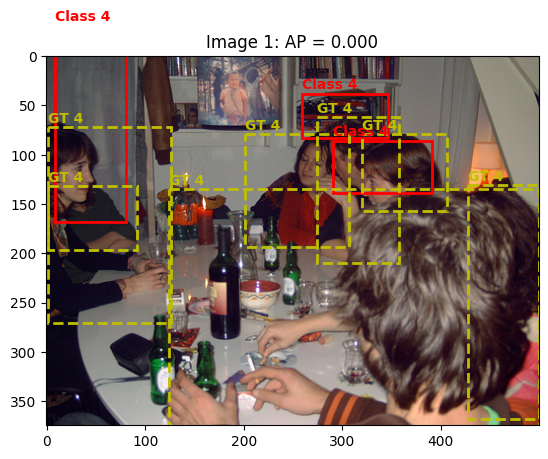

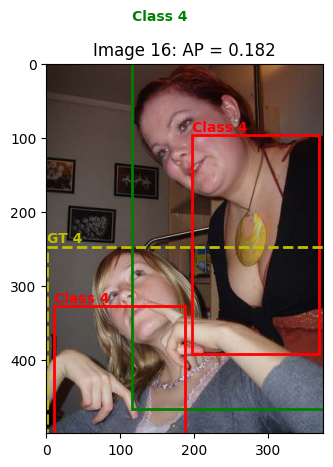

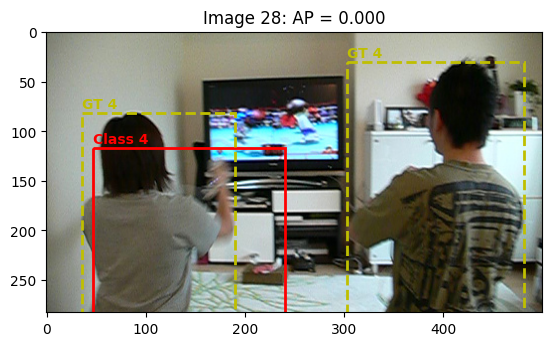

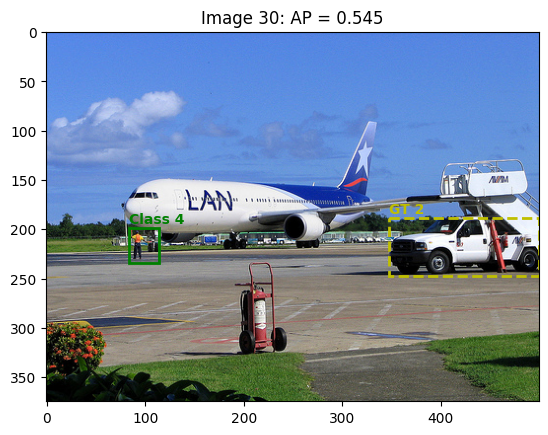

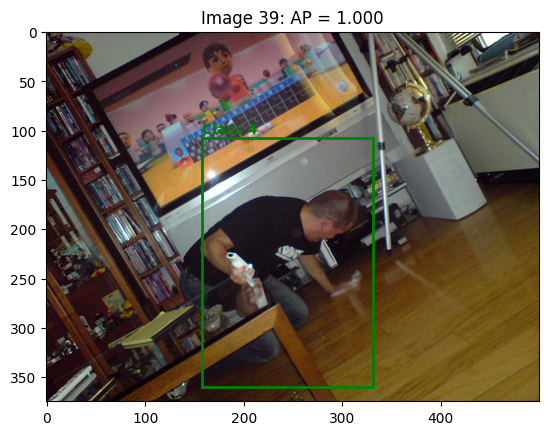

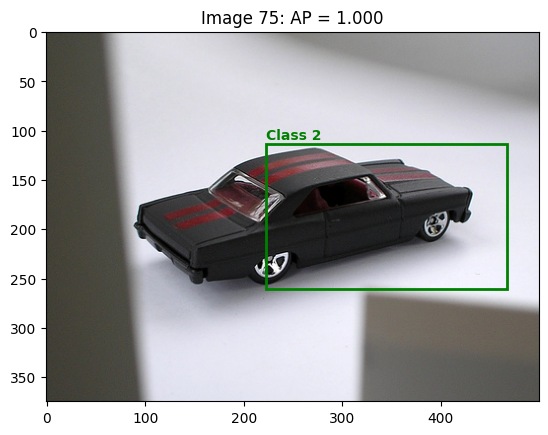

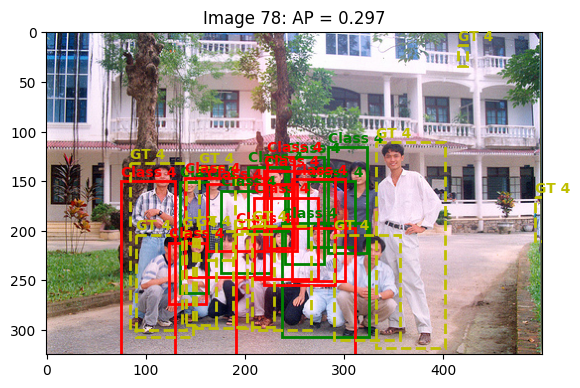

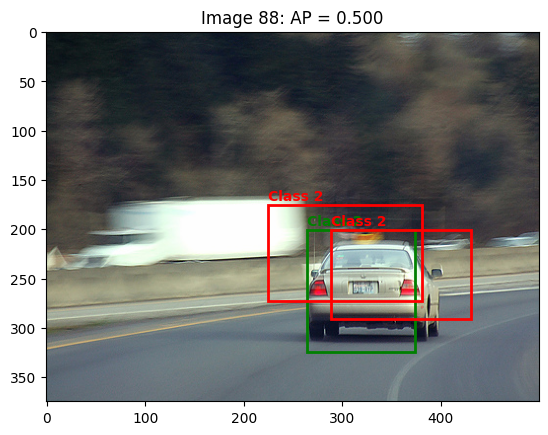

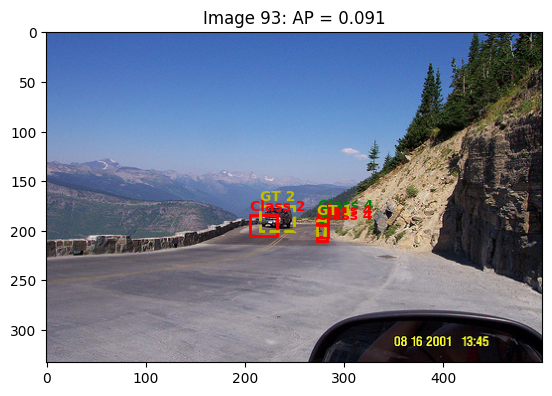

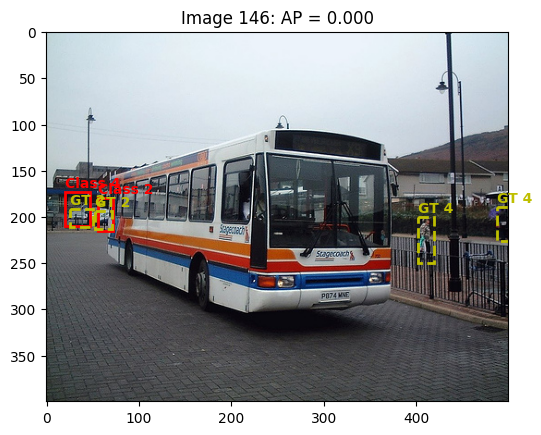

Overall mAP on test set: 0.253


([{'image_index': 0,
   'ap': 0.0,
   'correct': [],
   'incorrect': [{'class': 4,
     'a': 1.3651378154754639,
     'rectangle': (8.744145631790161,
      -31.10166844725609,
      80.64639091491699,
      168.73842924833298)},
    {'class': 4,
     'a': 1.093756914138794,
     'rectangle': (290.851628780365,
      85.97098526358604,
      390.7924818992615,
      139.06949961185455)},
    {'class': 4,
     'a': 0.8988930583000183,
     'rectangle': (258.6598434448242,
      38.0688339471817,
      346.28349113464355,
      82.99622011184692)}],
   'missed': [{'class': 4, 'rectangle': (1, 132, 92, 197)},
    {'class': 4, 'rectangle': (1, 72, 126, 271)},
    {'class': 4, 'rectangle': (124, 135, 500, 375)},
    {'class': 4, 'rectangle': (428, 131, 500, 368)},
    {'class': 4, 'rectangle': (320, 79, 406, 157)},
    {'class': 4, 'rectangle': (201, 79, 307, 194)},
    {'class': 4, 'rectangle': (274, 62, 358, 210)}],
   'detections': [{'class': 4,
     'a': 1.3651378154754639,
     'rectan

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def convert_box_to_image_coords(pred_box, candidate_box):
    """
    Converts a predicted bounding box (normalized relative to the candidate region)
    to the original image coordinates.
    
    pred_box: [x0, y0, x1, y1] with values in [0, 1]
    candidate_box: [cx0, cy0, cx1, cy1] in original image coordinates.
    """
    cx0, cy0, cx1, cy1 = candidate_box
    width = cx1 - cx0
    height = cy1 - cy0
    im_x0 = cx0 + pred_box[0] * width
    im_y0 = cy0 + pred_box[1] * height
    im_x1 = cx0 + pred_box[2] * width
    im_y1 = cy0 + pred_box[3] * height
    return (im_x0, im_y0, im_x1, im_y1)

def test_and_post_process(model, test_loader, device, display_indices=[1,16,28,30,39,75,78,88,93,146]):
    model.eval()
    all_ap = []
    all_results = []
    
    for idx, data in enumerate(test_loader):
        # Each sample returns: original image, candidate_regions, candidate_boxes, gt_bboxes, gt_labels.
        # Because batch_size=1, squeeze out the batch dimension.
        original_image, candidate_regions, candidate_boxes, gt_bboxes, gt_labels = data
        
        # candidate_regions: shape (1, N, 3, 224, 224) -> remove batch dim to get (N, 3, 224, 224)
        candidate_regions = candidate_regions.squeeze(0)
        # candidate_boxes is a Python list wrapped in a batch; extract the first element.
        candidate_boxes = candidate_boxes[0]
        # print(f"Image {idx}: candidate_boxes = {candidate_boxes}")
        
        #flatten if still wrapped in an extra dimension)
        if candidate_regions.dim() == 5:
            #in case it has shape (1, N, 3, 224, 224)
            candidate_regions = candidate_regions.view(-1, candidate_regions.size(2), candidate_regions.size(3), candidate_regions.size(4))
        candidate_regions = candidate_regions.to(device)
        
        #forward pass through the model
        with torch.no_grad():
            class_out, regress_out = model(candidate_regions)
            # class_out: (N, num_classes+1)
            # regress_out: (N, num_object_classes, 4)
        
        #build list of prediction dictionaries
        predictions = []
        N = candidate_regions.shape[0]
        for i in range(N):
            pred_scores = class_out[i]
            pred_label = int(torch.argmax(pred_scores).item())
            activation = float(torch.max(pred_scores).item())
            pred_dict = {"class": pred_label, "a": activation}
            
            # Process only if candidate_boxes[i] appears valid
            candidate_box = candidate_boxes[i]
            #tensor, convert it to a list
            candidate_box = candidate_box.tolist()
            
            if pred_label != 0:
                pred_box_norm = regress_out[i, pred_label - 1, :].cpu().numpy()  # normalized (0,1)
                pred_box_img = convert_box_to_image_coords(pred_box_norm, candidate_box)
                pred_dict["rectangle"] = pred_box_img
            else:
                pred_dict["rectangle"] = candidate_box
            
            predictions.append(pred_dict)
        
        #filtering and nms
        detections = predictions_to_detections(predictions, iou_threshold=0.5)
        
        # Prepare ground truth in the expected format: a list of dicts with keys "class" and "rectangle"
        gt_list = []
        for bbox, label in zip(gt_bboxes[0], gt_labels[0]):
            if isinstance(bbox, torch.Tensor):
                bbox = bbox.tolist()

            if not (isinstance(bbox, (list, tuple)) and len(bbox) == 4):
                print(f"Warning: For image {idx}, a ground truth box is malformed: {bbox}")
                continue

            gt_list.append({"class": int(label), "rectangle": tuple(bbox)})
        
        #evaluate detections
        correct_dets, incorrect_dets, missed_gt, ap = evaluate(detections, gt_list, iou_threshold=0.5)
        all_ap.append(ap)
        all_results.append({
            "image_index": idx,
            "ap": ap,
            "correct": correct_dets,
            "incorrect": incorrect_dets,
            "missed": missed_gt,
            "detections": detections,
            "gt": gt_list
        })
        
        # Display selected images with drawn detections
        if (idx + 1) in display_indices:
            fig, ax = plt.subplots(1)
            ax.imshow(original_image.squeeze(0).cpu().numpy().astype(np.uint8))
            for det in correct_dets:
                rect = det["rectangle"]
                width = rect[2] - rect[0]
                height = rect[3] - rect[1]
                patch = patches.Rectangle((rect[0], rect[1]), width, height, linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(patch)
                ax.text(rect[0], rect[1]-5, f"Class {det['class']}", color='g', fontsize=10, weight='bold')
            for det in incorrect_dets:
                rect = det["rectangle"]
                width = rect[2] - rect[0]
                height = rect[3] - rect[1]
                patch = patches.Rectangle((rect[0], rect[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(patch)
                ax.text(rect[0], rect[1]-5, f"Class {det['class']}", color='r', fontsize=10, weight='bold')
            for gt in missed_gt:
                rect = gt["rectangle"]
                width = rect[2] - rect[0]
                height = rect[3] - rect[1]
                patch = patches.Rectangle((rect[0], rect[1]), width, height, linewidth=2, edgecolor='y', facecolor='none', linestyle='--')
                ax.add_patch(patch)
                ax.text(rect[0], rect[1]-5, f"GT {gt['class']}", color='y', fontsize=10, weight='bold')
            ax.set_title(f"Image {idx+1}: AP = {ap:.3f}")
            plt.show()
    
    mAP = np.mean(all_ap) if all_ap else 0.0
    print(f"Overall mAP on test set: {mAP:.3f}")
    return all_results, mAP


test_dataset   = HW5DatasetTest("./test", "./test_json/test.json")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)
test_and_post_process(model, test_loader, device)

